<a href="https://colab.research.google.com/github/ganesh3/pytorch-work/blob/master/ViT_Image_Patch_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have built this colab notebook by referring to Misha Laskin tweet. It is essentially a reproduction of the concepts & code in his tweets https://twitter.com/MishaLaskin/status/1478500256040071173

Patch extraction is a fundamental operation in deep learning, especially for computer vision where it is used in the ViT architecture.
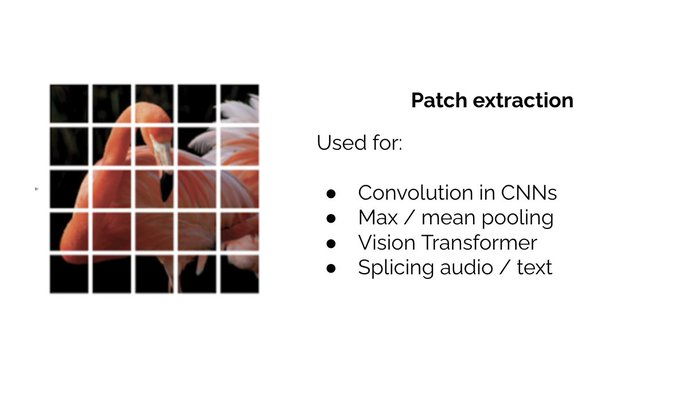

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def nonOverlappingPatches(img, size):
  H,W = img.shape
  rows, cols = H // size, W // size

  #initialize patch placeholder
  patches = np.zeros((rows, cols, size, size))

  #fill in patches
  for i in range(rows):
    for j in range(cols):
      patches += img[size*i : size* (i+1), size*j : size*(j+1)]
      #plt_imshow("Patches", patches)
  
  return patches

In [4]:
#I have taken an image from Adrian's pyimagesearch blog which has the image of april tag.
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/python-apriltag/python-apriltag.zip
!unzip -qq python-apriltag.zip
%cd python-apriltag

--2022-01-13 08:51:28--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/python-apriltag/python-apriltag.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.148.250
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.148.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978333 (955K) [application/zip]
Saving to: ‘python-apriltag.zip’

python-apriltag.zip 100%[===================>] 955.40K  1.19MB/s    in 0.8s    

2022-01-13 08:51:29 (1.19 MB/s) - ‘python-apriltag.zip’ saved [978333/978333]

/content/python-apriltag


In [5]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
  if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(title)
  plt.grid(False)
  plt.show()

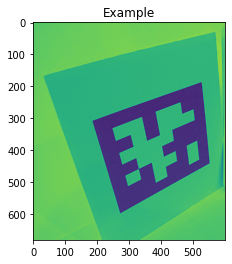

In [6]:
image = cv2.imread("/content/python-apriltag/images/example_01.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("Example", image)

In [7]:
image.shape

(680, 600)

In [8]:
size = 16
patches = nonOverlappingPatches(image, size)

In [9]:
patches.shape

(42, 37, 16, 16)

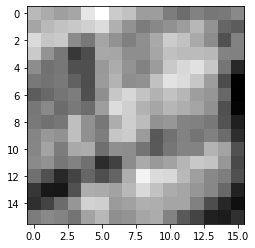

In [11]:
plt.imshow(np.squeeze(patches[0, 0]), cmap="gray")

We can make patch extraction fast and lightweight by leveraging how numpy (or torch, tf, jax, etc) stores arrays in memory. Numpy stores arrays in contiguous memory. This structure makes reading data from the image array very efficient.  
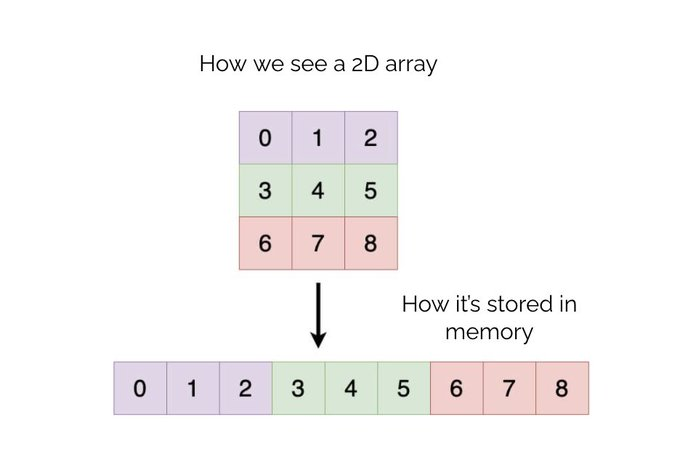

Instead of creating a new patches array, we only need to specify how to view the image as an array of patches. This is where the concept of strides comes in. You’ll notice that each numpy array has shape, strides, and itemsize properties. What do these properties mean?

In [12]:
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]).astype(np.float32)

In [13]:
print('shape', arr.shape, 'strides', arr.strides, 'itemsize', arr.itemsize)

shape (3, 3) strides (12, 4) itemsize 4


Shape = dimension of array. Itemsize = the number of bytes per cell (float32 = 32 bits = 4 bytes). Strides = the number of bytes required to traverse the contiguous memory block to read the next element along a given dimension. Strides = # steps-to-traverse * itemsize.
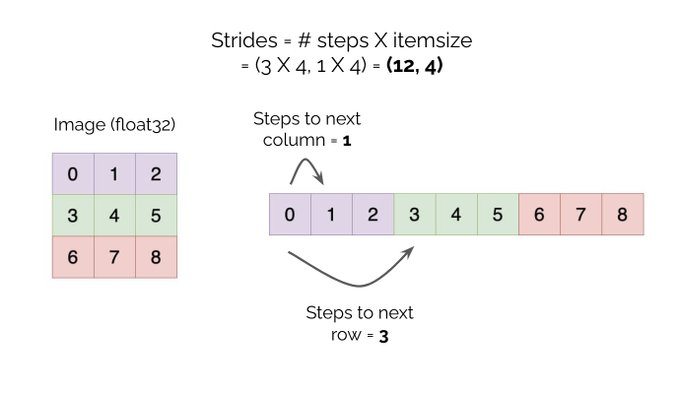

If we know the output shape of the patch tensor, we can then specify the strides appropriately to get the desired patches. In numpy, the stride_tricks module provides this functionality. For example, here is how you implement non-overlapping patch extraction (e.g. for ViT).

In [14]:
from numpy.lib import stride_tricks

In [15]:
H,W = image.shape
shape = [H // size, W // size] + [size, size]

In [16]:
image.strides

(600, 1)

In [17]:
shape

[42, 37, 16, 16]

In [18]:
strides = [size * s for s in image.strides] + list(image.strides)

In [19]:
strides

[9600, 16, 600, 1]

In [20]:
patches = stride_tricks.as_strided(image, shape=shape, strides = strides)

In [21]:
patches.shape

(42, 37, 16, 16)

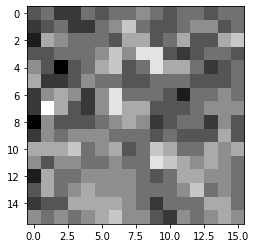

In [22]:
plt.imshow(np.squeeze(patches[0, 0]), cmap="gray")

stride_tricks.as_strided is a general purpose function for viewing any array. By specifying the shape and strides we fully define how to traverse this array for viewing. In our case we want to view it as patches - the main trick is to figure out the correct strides.

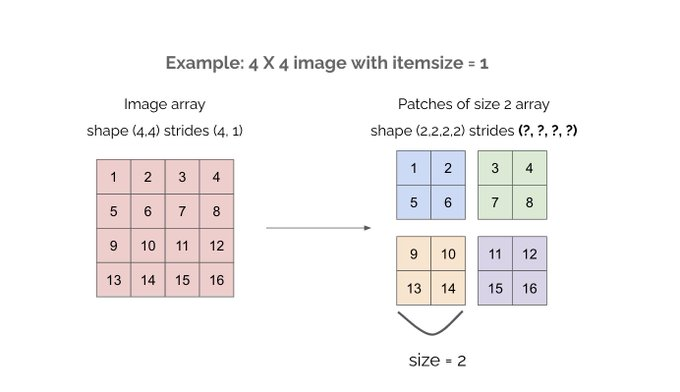

The best way to understand how to specify strides is to work through each dimension in the output shape. For each dimension ask - how many steps needs to be traversed to access the next element along this dimension?

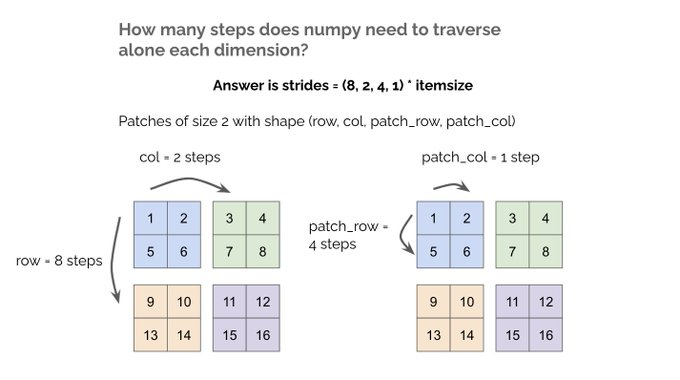

We've now learned how to efficiently extract patches from grayscale images. What about RGB images - how do we deal with the channel dimension? Turns out the fix is quite simple. We just need to modify the row & col strides to ignore the channel dimension.
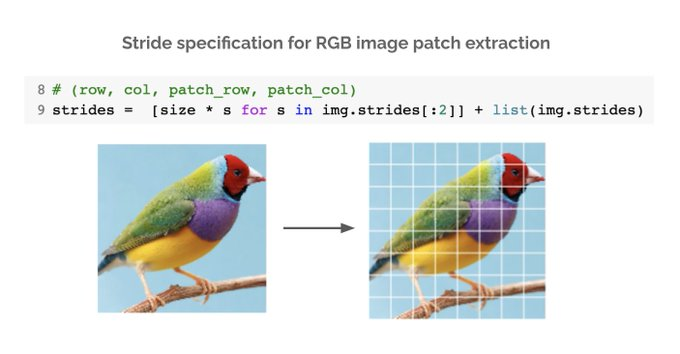